In [6]:
import sys
sys.path += ["../src"]
import utils
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
import shapely
import scipy.stats
import geopandas as gpd
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict

from _51_abm_functions import cod_prov_abbrv_df

# Global Spatial Autocorrelation
from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
from spatial_autocorrelation import get_localMoransI, LISA_scatterplot

In [7]:
def add_cat_features(df):
    df["energy_class"] = df[[u for u in df.columns if "_energy" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]
    df["COD_CAT"] = [u[8:] for u in df[[u for u in df.columns if "COD_CAT_" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    df["anno_costruzione"] = [u[17:] for u in df[[u for u in df.columns if "ANNO_COSTRUZIONE" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    return df
# 
def Aggregate_attribute_in_grid(data, grid, agg_rules, density =True ):
    '''
    Discretize space ina grid and count the number of homes in each grid cell.
    '''
    if type(data)== pd.DataFrame:
        # find coords
        geo_coordinates = gpd.points_from_xy(data.x, data.y,crs="EPSG:4326")
        data = gpd.GeoDataFrame(data, geometry=geo_coordinates)
    else: 
        data = data.set_geometry('geometry', crs="EPSG:4326")
        
    # Assing homes to grid cells
    merged = gpd.sjoin(data, grid, how='left', predicate='within')
    merged = merged.drop(columns='geometry').merge(grid, left_on='index_right', right_index=True, suffixes=('', '_grid'),how='left')
    
    merged['num_homes'] = 1 # add for counting homes

    # Aggregate by grid cell
    grid_aggregate = merged.groupby('index_right').agg(agg_rules).reset_index().rename(columns={'index_right': 'grid_id'})
    
    '''
    if metric == 'sum':
        grid_aggregate = merged.loc[:,[attribute,'index_right']].groupby('index_right').sum().reset_index().rename(columns={'index_right': 'grid_id'})
    elif metric == 'mean':
        grid_aggregate = merged.loc[:,[attribute,'index_right']].groupby('index_right').mean().reset_index().rename(columns={'index_right': 'grid_id'})'''
    grid_aggregate = gpd.GeoDataFrame(pd.merge(grid_aggregate, grid, left_on='grid_id',right_index=True, how='right')).reset_index(drop=True)
    #grid_aggregate.fillna(0, inplace=True)

    # Find grid cells inside the province
    grid_aggregate = gpd.sjoin(grid_aggregate, province_shapefile, how='left', predicate='intersects').drop(columns='index_right')
    grid_aggregate['in_province'] = grid_aggregate['in_province'].fillna(0)
    grid_aggregate.set_geometry('geometry', crs ="EPSG:4326",inplace=True)

    # normalise each column
    if density==True:
        for col in agg_rules.keys():
            grid_aggregate[col] = grid_aggregate[col] / grid_aggregate[col].sum()

    # convert to centroids
    # cast into matrix (grid with centroids)
    #grid_aggregate = grid_aggregate.set_index('geometry').reset_index()
    grid_aggregate['x'] = grid_aggregate['geometry'].apply(lambda x: x.centroid.x)
    grid_aggregate['y'] = grid_aggregate['geometry'].apply(lambda x: x.centroid.y)

    #grid_aggregate.set_geometry('geometry', crs ="EPSG:4326",inplace=True)

    #grid_aggregate = grid_list.pivot(index='y', columns='x', values=attribute).fillna(0)

    return grid_aggregate

# 
def Grid_count_homes(data,grid):
    '''
    Discretize space ina grid and count the number of homes in each grid cell.
    '''
    if type(data)== pd.DataFrame:
        # find coords
        geo_coordinates = gpd.points_from_xy(data.x, data.y,crs="EPSG:4326")
        data = gpd.GeoDataFrame(data, geometry=geo_coordinates)
    else: 
        data = data.set_geometry('geometry', crs="EPSG:4326")
        
    merged = gpd.sjoin(data, grid, how='left', predicate='within')
    merged = merged.drop(columns='geometry').merge(grid, left_on='index_right', right_index=True, suffixes=('', '_grid'),how='left')
    # count num homes per grid
    grid_count = merged.groupby('index_right').size().reset_index(name='num_homes')

    grid_count = gpd.GeoDataFrame(pd.merge(grid_count, grid, left_on='index_right',right_index=True, how='right')).reset_index(drop=True)

    # estimate probability from num_homes
    grid_count['num_homes'] = grid_count['num_homes'].astype(float)
    grid_count['num_homes'] = grid_count['num_homes'] / grid_count['num_homes'].sum()
    
    #grid_count['num_homes'] = grid_count['num_homes'].fillna(0)
    #grid_count = gpd.GeoDataFrame(merged.loc[:,['num_homes','index_right','geometry']]).dissolve(by="index_right", aggfunc="count")

    # plot 
    fig, ax = plt.subplots(figsize=(10,5))
    grid_count.plot(column='num_homes', ax=ax, legend=True, cmap='viridis', edgecolor='black')
    province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax, color='lightgray', markersize=0.1, alpha=0.5)

    # earth mover distance
    grid_count.fillna(0, inplace=True)
    grid_count= grid_count [['num_homes','geometry']]

    # convert to centroids
    # cast into matrix (grid with centroids)
    grid_count = grid_count.set_index('geometry').reset_index()
    grid_count['x'] = grid_count['geometry'].apply(lambda x: x.centroid.x)
    grid_count['y'] = grid_count['geometry'].apply(lambda x: x.centroid.y)
    centroids = grid_count[['x', 'y']].copy()

    grid_list = grid_count.set_index(['x', 'y']).reset_index()

    grid_count = grid_list.pivot(index='y', columns='x', values='num_homes').fillna(0)

    # find centroids

    #df_real.plot(ax=ax, color='red', markersize=0.1, alpha=0.5)
    return grid_count, centroids, grid_list

def create_grid(province_shapefile,cell_size_lat, cell_size_long):
 #total area for the grid
    xmin, ymin, xmax, ymax=province_shapefile.total_bounds
    # how many cells across and down
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size_long, cell_size_long ):
        for y0 in np.arange(ymin, ymax+cell_size_lat, cell_size_lat):
            # bounds
            x1 = x0+cell_size_long
            y1 = y0-cell_size_lat
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                    crs=crs)
    return grid


# LOAD NEW BASELINES

In [8]:
import pickle

prov = "AN"

with open(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle', 'rb') as f:
    all_baselines = pickle.load(f)


all_baselines.keys()

# 

df_real = all_baselines['df_real']
df_nfvae= all_baselines['df_nfvae']
df_ablation= all_baselines['df_ablation']
df_ipf = all_baselines['df_ipf']
df_copula_nf = all_baselines['df_copula_nf']
df_copula_ablation = all_baselines['df_copula_ablation']



'''
# Drop index_right column (all 0)
df_nfvae = df_nfvae.drop(columns=['index_right'])
df_ablation = df_ablation.drop(columns=['index_right'])
df_copula_nf = df_copula_nf.drop(columns=['index_right'])
df_copula_ablation = df_copula_ablation.drop(columns=['index_right'])
df_ipf = df_ipf.drop(columns=['index_right'])'''



KeyError: 'df_ipf'

In [9]:

# Variables
continuous_var = ['log_mq','log_price']
ignore = ['x', 'y', 'SEZ2011', 'PRO_COM', 'CAP', 'OMI_id', 'prov_abbrv', 'energy_class', 'COD_CAT',
       'anno_costruzione', 'COD_REG', 'COD_PROV']

categoricals = list(set(df_real.columns).difference(set(continuous_var + ignore)))


# transform categoricals to numeric
for col in categoricals:
    if col in df_real.columns:
        df_real[col] = df_real[col].astype(float)
    if col in df_nfvae.columns:
        df_nfvae[col] = df_nfvae[col].astype(float)
    if col in df_copula_ablation.columns:
        df_copula_ablation[col] = df_copula_ablation[col].astype(float)
    if col in df_copula_nf.columns:
        df_copula_nf[col] = df_copula_nf[col].astype(float)
    if col in df_ablation.columns:
        df_ablation[col] = df_ablation[col].astype(float)
    if col in df_ipf.columns:
        df_ipf[col] = df_ipf[col].astype(float)


NameError: name 'df_copula_ablation' is not defined

NameError: name 'df_copula_ablation' is not defined

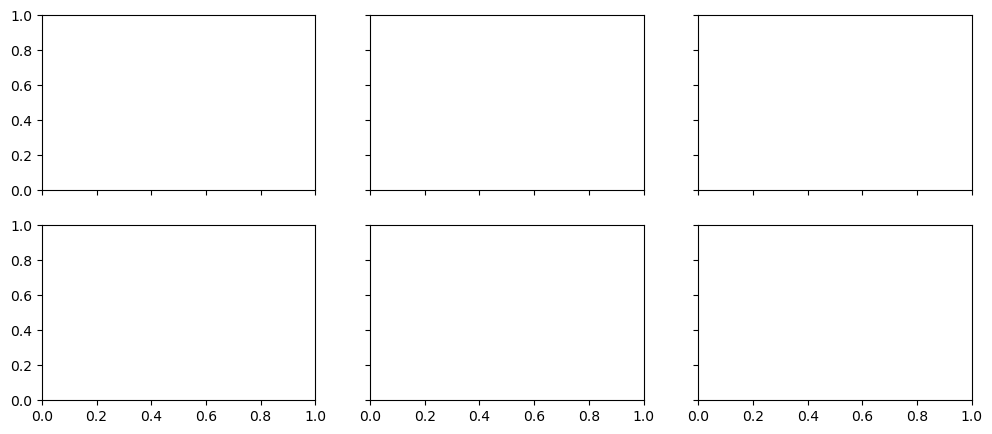

In [5]:
plot_var= 'flag_garage'
fig, axes = sbp(nrows=2,ncols = 3, figsize = (12,5), sharex = True, sharey = True)
axes = axes.flatten()
for j,df_plot in enumerate([df_real.assign(flag_garage = lambda x: x[plot_var] == 1), df_nfvae, df_ablation,
                            df_copula_ablation, df_copula_nf, df_ipf]):
    
    sns.scatterplot(data = df_plot,
                    hue = plot_var,
                    # hue = "flag_garage",
                    x = "x", y = "y", s = 2, ax = axes[j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[j].set_title("Dati " + ["reali", "sintetici", "ablation",'copula','copula +nf','ipf'][j] + " - " + prov, fontsize = 19)
    axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_visible(False)
    axes[j].legend().set_visible(False)
    #axes[j].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")

# plt make common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title = plot_var, loc='lower center', ncol=2, fontsize=12, title_fontsize=12, frameon=False)


# Prepare null models: random cordinates and shuffling

In [14]:
str(cod_prov).zfill(3)

'042'

In [ ]:
# Load shapefile of the region
def Find_province_shapefile_old(df_real):
    region= df_real.COD_REG.drop_duplicates().values[0].astype(str).zfill(2)

    region_shapefile = gpd.read_file(f'/data/housing/data/input/census/shapefiles_2011/R{region}_11_WGS84/R{region}_11_WGS84.shp')

    # filter prov
    df_real['COD_PROV']= df_real['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x))).str[:3]
    cod_prov= df_real.COD_PROV.drop_duplicates().values[0]
    region_shapefile['PRO_COM'] = region_shapefile['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x)))

    # keep shapefile of the province
    region_shapefile['COD_PROV']= region_shapefile['PRO_COM'].astype(str).str[:3]
    province_shapefile= region_shapefile.loc[region_shapefile.COD_PROV == cod_prov, "geometry"].reset_index().dissolve()
    province_shapefile.to_crs(epsg=4326, inplace=True)
    province_shapefile['index']=1
    province_shapefile.rename(columns={'index': 'in_province'}, inplace=True)  #needed for the next steps

    return province_shapefile

def Find_province_shapefile(prov_code,reg_code):

    # fill reg_code 0 

    reg_code = str(reg_code).zfill(2)  # ensure reg_code is two digits

    region_shapefile = gpd.read_file(f'/data/housing/data/input/census/shapefiles_2011/R{reg_code}_11_WGS84/R{reg_code}_11_WGS84.shp')
    region_shapefile['PRO_COM'] = region_shapefile['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x)))
    #province 
    prov_code =str(prov_code).zfill(3)  # ensure prov_code is three digits
    #keep 3 first digits of PRO_COM as COD_PROV
    region_shapefile['COD_PROV'] = region_shapefile['PRO_COM'].str[0:3]
    # filter prov
    province_shapefile= region_shapefile.loc[region_shapefile.COD_PROV == prov_code, "geometry"].reset_index().dissolve()
    province_shapefile.to_crs(epsg=4326, inplace=True)
    province_shapefile['index']=1
    province_shapefile.rename(columns={'index': 'in_province'}, inplace=True)  #needed for the next steps

    return province_shapefile


def Shuffle_attributes(data, attributes_shuffle, rand_geo, rand_attributes):
    if rand_attributes: 
        for attribute in attributes_shuffle: 
            if attribute !='num_homes': 
                data[attribute] = np.random.permutation(data[attribute].values)
        
    if rand_geo: 
        # Randomly shuffle the geometry of the homes
        geo =  province_shapefile.sample_points(len(data)).explode('geometry').reset_index(drop=True)
        data['x'] = geo.x
        data['y'] = geo.y
    return data

agg_rules = {
    'num_homes': 'sum',
    'flag_garage': 'mean',
    'flag_air_conditioning': 'mean',
    'flag_multi_floor': 'mean',
    'flag_pertinenza': 'mean',
    'log_mq': 'mean',
    'COD_CAT': 'first',
    'anno_costruzione': 'first',
    'energy_class': 'first',
}

# Add cod_reg to data 
metadata  = pd.read_csv('/data/housing/data/intermediate/master_table_locations.csv')
cod_prov = int(cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0])

metadata_reg = pd.read_csv('/data/housing/data/intermediate/master_table_regressions.csv')
cod_reg = metadata_reg.loc[metadata_reg['COD_PROV'] == cod_prov, 'COD_REG'].unique()[0]

# Cut province shapefile
province_shapefile = Find_province_shapefile(cod_prov,cod_reg)

# Add categorical features
df_real = add_cat_features(df_real)
df_nfvae = add_cat_features(df_nfvae)
df_ablation = add_cat_features(df_ablation)
df_copula_ablation = add_cat_features(df_copula_ablation)
df_copula_nf = add_cat_features(df_copula_nf)
df_ipf = add_cat_features(df_ipf)

# Generate 2 null models: 
# 1. Randomly shuffle the geographical coordinates of the homes
df_null = Shuffle_attributes(df_real.copy(deep=True).reset_index(drop=True), agg_rules.keys(), rand_geo = True, rand_attributes =False)

# 2. Randomly shuffle the attributes of the homes (keeping the coordinates constant)
df_feat_shuffle = Shuffle_attributes(df_real.copy(deep=True).reset_index(drop=True), agg_rules.keys(), rand_geo = False, rand_attributes =True)


# Visualisation histogram in grid

Text(0.5, 1, 'Distribution of flag_garage in the province of AN')

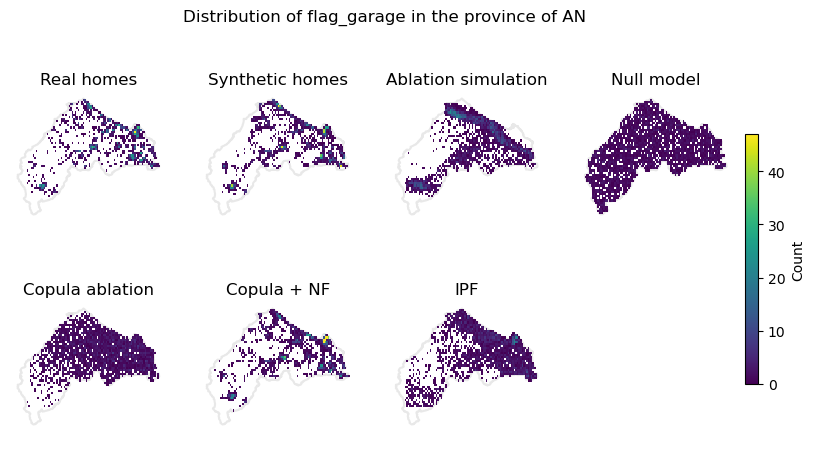

In [17]:

# Create grid for histogram
cell_size_lat = 0.01 # ~1kmx1km theoretically
cell_size_long = 0.01

grid = create_grid(province_shapefile, cell_size_lat, cell_size_long)

#fig, ax = plt.subplots(figsize=(10, 6))
#grid.boundary.plot(ax=ax, edgecolor='black', alpha=0.5)
#province_shapefile.plot(ax=ax, color='red', markersize=0.1, alpha=0.5)

# GRID AGGREGATE Generalised
# define rule for aggregating the data


#combine dictionaries
agg_rules = { var: 'mean' for var in continuous_var }
agg_rules.update({ var: 'sum' for var in categoricals })
agg_rules.update({'num_homes': 'sum'})

# 

grid_real = Aggregate_attribute_in_grid(df_real, grid, agg_rules, density = False)
grid_nfvae = Aggregate_attribute_in_grid(df_nfvae, grid, agg_rules, density = False)
grid_ablation = Aggregate_attribute_in_grid(df_ablation, grid, agg_rules, density = False)
grid_copula = Aggregate_attribute_in_grid(df_copula_ablation, grid, agg_rules, density = False)
grid_copula_nf = Aggregate_attribute_in_grid(df_copula_nf, grid, agg_rules, density = False)
grid_ipf = Aggregate_attribute_in_grid(df_ipf, grid, agg_rules, density = False)
grid_null = Aggregate_attribute_in_grid(df_null, grid, agg_rules,density=False)
#grid_shuffle= Aggregate_attribute_in_grid(df_feat_shuffle, grid, agg_rules, density = True)


# replace 0 by nan
#grid_real = grid_real.replace(0, np.nan)
#grid_nfvae = grid_nfvae.replace(0, np.nan)
#grid_null = grid_null.replace(0, np.nan)


attribute= 'flag_garage' # 'flag_garage', 'flag_multi_floor', 'log_mq', 'flag_pertinenza'

max_cbar = np.max([np.max(grid_real[attribute]), np.max(grid_nfvae[attribute]), np.max(grid_null[attribute]), 
                   np.max(grid_ablation[attribute]), np.max(grid_copula[attribute]), np.max(grid_ipf[attribute])])

fig, ax = plt.subplots(2,4,figsize=(10,5),sharex=True, sharey=True)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][0], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][1], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][2], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[0][3], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[1][0], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[1][1], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)
province_shapefile.to_crs("EPSG:4326").boundary.plot(ax=ax[1][2], color='lightgray', markersize=0.1, alpha=0.5,zorder=1)

grid_real.loc[grid_real['in_province'] == 1].plot(column=attribute, cmap='viridis' ,ax=ax[0][0],zorder=3,vmax=max_cbar)
grid_nfvae.loc[grid_nfvae['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[0][1],zorder=3, vmax=max_cbar)
grid_ablation.loc[grid_ablation['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[0][2],zorder=3, vmax=max_cbar)
grid_null.loc[grid_null['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[0][3],zorder=3, vmax=max_cbar)
grid_copula.loc[grid_copula['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[1][0],zorder=3, vmax=max_cbar)
grid_copula_nf.loc[grid_copula_nf['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[1][1],zorder=3, vmax=max_cbar)
grid_ipf.loc[grid_ipf['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[1][2],zorder=3, vmax=max_cbar)
#grid_shuffle.loc[grid_shuffle['in_province'] == 1].plot(column=attribute, cmap='viridis', ax=ax[1][1],zorder=3, vmax=max_cbar)
ax[0][0].set_title("Real homes")
ax[0][1].set_title("Synthetic homes")
ax[0][2].set_title("Ablation simulation")
ax[0][3].set_title("Null model")
ax[1][0].set_title("Copula ablation")
#ax[1][1].set_title("Shuffled features")
ax[1][1].set_title("Copula + NF")
ax[1][2].set_title("IPF")

# remove axis and spines
for a in ax.flatten():
    a.set_axis_off()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)

# make common colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.25, 0.013, 0.5]) #left, bottom, width, height
cbar = fig.colorbar(ax[0][0].collections[1], cax=cbar_ax)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_ticks_position('right')
cbar.set_label(f"Count")
# define max cbar

fig.suptitle(f"Distribution of {attribute} in the province of {prov}", fontsize=12, y=1, ha='center')

## Wasserstein distance: HOME LOCATION

(single homes)

In [20]:
# Test wasserstein distance (no bins): Compare position homes in the grid
import ot 
from joblib import Parallel, delayed

n_projections = 200 #10000
'''SWD = {'real_vs_sample' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_sample[['x', 'y']].to_numpy(), n_projections=n_projections),
            'real_vs_null' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), n_projections=n_projections),
            'real_vs_abl' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_sample_abl[['x', 'y']].to_numpy(), n_projections=n_projections),
            'real_vs_shuffle' :  ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), n_projections=n_projections),
            'sample_vs_null' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), n_projections=n_projections),
            'sample_vs_shuffle' : ot.sliced_wasserstein_distance(df_sample[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), n_projections=n_projections)}
'''


SWD = {'real_vs_nfvae' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_nfvae[['x', 'y']].to_numpy(), n_projections=n_projections),
    'real_vs_ablation': ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_ablation[['x', 'y']].to_numpy(), n_projections=n_projections),
    'real_vs_copula': ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_copula_ablation[['x', 'y']].to_numpy(), n_projections=n_projections),
    'real_vs_copula_nf': ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_copula_nf[['x', 'y']].to_numpy(), n_projections=n_projections),
    'real_vs_ipf': ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_ipf[['x', 'y']].to_numpy(), n_projections=n_projections),
    'real_vs_null' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), n_projections=n_projections),
    'nfvae_vs_null' : ot.sliced_wasserstein_distance(df_nfvae[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), n_projections=n_projections)}#,
    #'real_vs_shuffle' :  ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), n_projections=n_projections),
    #'sample_vs_shuffle' : ot.sliced_wasserstein_distance(df_nfvae[['x', 'y']].to_numpy(),df_feat_shuffle[['x', 'y']].to_numpy(), n_projections=n_projections)}
SWD_df = pd.DataFrame.from_dict(SWD, orient='index', columns=['Wasserstein distance'])

SWD_df

# 10000 = 2.13 min
# 5000 = 54s
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(SWD_df.index, SWD_df['Wasserstein distance'], color='skyblue')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Sliced Wasserstein distance')

NameError: name 'df_null' is not defined

## All provinces

In [28]:
CI.pivot(index='index', columns='level_1', values='Wasserstein distance').reset_index()


level_1,index,0.025,0.975
0,nfvae_vs_null,0.040916,0.252419
1,real_vs_ablation,0.033418,0.288214
2,real_vs_copula,0.013050,0.092800
3,real_vs_copula_nf,0.002914,0.048846
4,real_vs_ipf,0.006496,0.050389
5,real_vs_nfvae,0.009107,0.054343
6,real_vs_null,0.038773,0.272281


Text(0, 0.5, 'Mean Sliced Wasserstein distance')

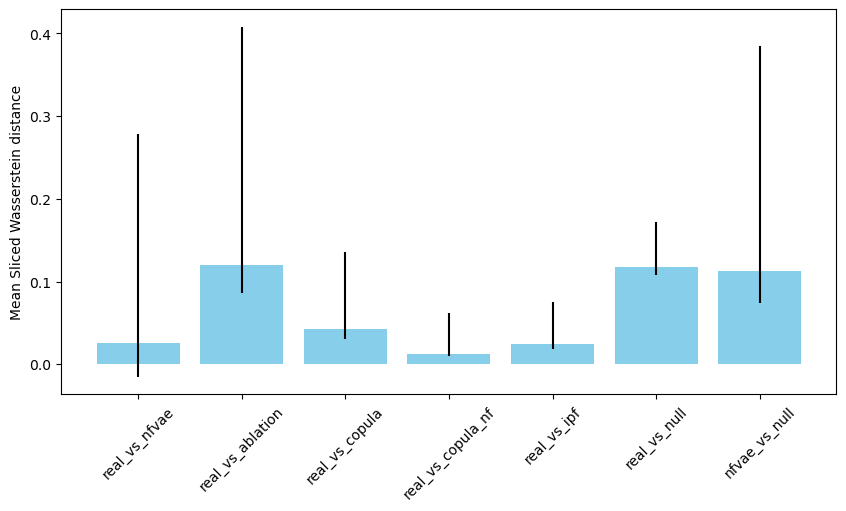

In [ ]:
all_prov = pd.read_csv('/data/housing/data/intermediate/jl_pop_synth/Sliced_WD_all_prov.txt', sep=',')
all_prov

mean_SWD = all_prov.groupby('index')['Wasserstein distance'].mean()

order = ['real_vs_nfvae','real_vs_ablation','real_vs_copula','real_vs_copula_nf','real_vs_ipf','real_vs_null','nfvae_vs_null']
mean_SWD = mean_SWD[order]
all_prov



# Confidence intervals
CI = all_prov.groupby('index')['Wasserstein distance'].quantile([0.025, 0.975]).reset_index()
CI=CI.pivot(index='index', columns='level_1', values='Wasserstein distance').reset_index()


#Barplot with error bars
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(mean_SWD.index, mean_SWD.values, color='skyblue',yerr = [mean_SWD- CI[0.025], CI[0.975]])
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Mean Sliced Wasserstein distance')

## Wasserstein distance: OTHER ATTRIBUTES
(single homes)

In [26]:
# Test wasserstein distance (no bins): Compare position homes in the grid
import ot 
from joblib import Parallel, delayed
n_projections = 5000
attributes = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning', 'flag_multi_floor','log_mq'] 
# can't do price corrected until we fix the top part of the code

SWD_mat = pd.DataFrame(columns=['real_vs_nfvae', 'real_vs_ablation', 'real_vs_copula', 'real_vs_copula_nf', 'real_vs_ipf', 'real_vs_null','nfvae_vs_null'], index=attributes)
for i in attributes: 
    SWD_mat.loc[i,:] = {'real_vs_nfvae' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_nfvae[['x', 'y']].to_numpy(), df_real[i].to_numpy(),df_nfvae[i].to_numpy(),
                                                                          n_projections=n_projections),
                'real_vs_ablation': ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_ablation[['x', 'y']].to_numpy(), df_real[i].to_numpy(),df_ablation[i].to_numpy(),
                                                                            n_projections=n_projections),                                                  
                'real_vs_copula' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_copula_ablation[['x', 'y']].to_numpy(), df_real[i].to_numpy(),df_copula_ablation[i].to_numpy(),
                                                                            n_projections=n_projections),
                'real_vs_copula_nf' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_copula_nf[['x', 'y']].to_numpy(), df_real[i].to_numpy(),df_copula_nf[i].to_numpy(),
                                                                            n_projections=n_projections),
                'real_vs_ipf' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_ipf[['x', 'y']].to_numpy(), df_real[i].to_numpy(),df_ipf[i].to_numpy(),
                                                                            n_projections=n_projections),
                'real_vs_null' : ot.sliced_wasserstein_distance(df_real[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), df_real[i].to_numpy(), df_null[i].to_numpy(),
                                                                n_projections=n_projections),
                'nfvae_vs_null' : ot.sliced_wasserstein_distance(df_nfvae[['x', 'y']].to_numpy(),df_null[['x', 'y']].to_numpy(), df_nfvae[i].to_numpy(), df_null[i].to_numpy(),
                                                                n_projections=n_projections)}
SWD_mat

,real_vs_nfvae,real_vs_ablation,real_vs_copula,real_vs_copula_nf,real_vs_ipf,real_vs_null,nfvae_vs_null
flag_garage,1.701537,4.243003,2.823094,1.260198,0.950207,7.037762,5.863556
flag_pertinenza,3.377495,4.023741,1.664544,0.352164,0.443188,2.140472,2.444518
flag_air_conditioning,0.690215,0.449498,0.707426,0.745566,0.462119,1.012184,1.288365
flag_multi_floor,0.262607,0.323478,0.574586,0.2503,0.464206,0.556257,0.629811
log_mq,4.007761,13.475945,8.928713,2.114404,2.221504,22.295079,19.825517


## Multidimensional attribute comparison: GRID

In [ ]:
## Provare anche
# pca distribuzione delle case  (non grid)
# PCA con 2 componenti, estimare su real e proiettare l'altro dataset... 
# Dopo usare KL divergence per vedere distanza. 


# Principal component analysis (PCA) on the attributes of the homes
from sklearn.decomposition import PCA



In [19]:

# GRID AGGREGATE Generalised
# define rule for aggregating the data
continuous_var = ['log_mq','log_price']
ignore = ['x', 'y', 'SEZ2011', 'PRO_COM', 'CAP', 'OMI_id', 'prov_abbrv', 'energy_class', 'COD_CAT',
       'anno_costruzione', 'COD_REG', 'COD_PROV']

categoricals = list(set(df_real.columns).difference(set(continuous_var + ignore)))

vars_compare = continuous_var + categoricals

#combine dictionaries
agg_rules = { var: 'mean' for var in continuous_var }
agg_rules.update({ var: 'sum' for var in categoricals })
agg_rules.update({'num_homes': 'sum'})

grid_real = Aggregate_attribute_in_grid(df_real, grid, agg_rules, density = False)
grid_nfvae = Aggregate_attribute_in_grid(df_nfvae, grid, agg_rules, density = False)
grid_ablation = Aggregate_attribute_in_grid(df_ablation, grid, agg_rules, density = False)
grid_copula = Aggregate_attribute_in_grid(df_copula_ablation, grid, agg_rules, density = False)
grid_copula_nf = Aggregate_attribute_in_grid(df_copula_nf, grid, agg_rules, density = False)
grid_ipf = Aggregate_attribute_in_grid(df_ipf, grid, agg_rules, density = False)


In [20]:

# transform categoricals in mean 
for var in categoricals:
    grid_real[var] = grid_real[var]/grid_real['num_homes']
    grid_nfvae[var] = grid_nfvae[var]/grid_nfvae['num_homes']
    grid_ablation[var] = grid_ablation[var]/grid_ablation['num_homes']
    grid_copula[var] = grid_copula[var]/grid_copula['num_homes']
    grid_copula_nf[var] = grid_copula_nf[var]/grid_copula_nf['num_homes']
    grid_ipf[var] = grid_ipf[var]/grid_ipf['num_homes']


In [21]:
# standardise data 
grid_real_std = (grid_real[vars_compare] - grid_real[vars_compare].mean(axis=0)) / grid_real[vars_compare].std(axis=0)
grid_nfvae_std = (grid_nfvae[vars_compare] - grid_nfvae[vars_compare].mean(axis=0)) / grid_nfvae[vars_compare].std(axis=0)
grid_ablation_std = (grid_ablation[vars_compare] - grid_ablation[vars_compare].mean(axis=0)) / grid_ablation[vars_compare].std(axis=0)
grid_copula_std = (grid_copula[vars_compare] - grid_copula[vars_compare].mean(axis=0)) / grid_copula[vars_compare].std(axis=0)
grid_copula_nf_std = (grid_copula_nf[vars_compare] - grid_copula_nf[vars_compare].mean(axis=0)) / grid_copula_nf[vars_compare].std(axis=0)
grid_ipf_std = (grid_ipf[vars_compare] - grid_ipf[vars_compare].mean(axis=0)) / grid_ipf[vars_compare].std(axis=0)


In [ ]:
# var
grid1= grid_real
grid2 = grid_nfvae
suffix1 = 'real'
suffix2 = 'nfvae'

def Diff_pixels(grid1, grid2,vars_compare):
    # Find common pixels
    grid1_clean = grid1[~ (grid1.num_homes.isna() | grid2.num_homes.isna())].reset_index(drop=True)
    grid2_clean = grid2[~ (grid1.num_homes.isna() | grid2.num_homes.isna())].reset_index(drop=True)
    print(f"Number of common pixels: {len(grid1_clean)}, {len(grid2_clean)}")
    difference = pd.DataFrame(index=grid1_clean.index, columns=vars_compare)
    for var in vars_compare:
        difference[var] = abs(grid1_clean[var] - grid2_clean[var])

    return difference

diff_real_nfvae = Diff_pixels(grid_real, grid_nfvae,vars_compare)

diff_real_copula_nf = Diff_pixels(grid_real, grid_copula_nf,vars_compare)

#  Mean Sum per pixel
mean_diff_real_nfvae = pd.Series(diff_real_nfvae.sum(axis=1),name= 'diff').mean()
mean_diff_real_ablation = pd.Series(Diff_pixels(grid_real, grid_ablation,vars_compare).sum(axis=1),name= 'diff').mean()
mean_diff_real_copula_nf= pd.Series(diff_real_copula_nf.sum(axis=1),name= 'diff').mean()
mean_diff_real_copula_ablation = pd.Series(Diff_pixels(grid_real, grid_copula,vars_compare).sum(axis=1),name= 'diff').mean()
mean_diff_real_ipf = pd.Series(Diff_pixels(grid_real, grid_ipf,vars_compare).sum(axis=1),name= 'diff').mean()

# Mean
print('real_nfvae:', mean_diff_real_nfvae)
print('real_ablation:', mean_diff_real_ablation)
print('real_copula_nf:', mean_diff_real_copula_nf)
print('real_copula_ablation:', mean_diff_real_copula_ablation)
print('real_ipf:', mean_diff_real_ipf)

Number of common pixels: 403, 403
Number of common pixels: 449, 449
Number of common pixels: 368, 368
Number of common pixels: 499, 499
Number of common pixels: 468, 468
real_nfvae: 4.445729051958464
real_ablation: 5.441775153099443
real_copula_nf: 4.587725402685551
real_copula_ablation: 5.224483028199758
real_ipf: 5.101387928179158


In [48]:

print(f"Missmatched missing values in {var_compare} for: {len(compare_grid.loc[(compare_grid.log_mq.isna()) & (~compare_grid.log_mq_nfvae.isna()),:]) + len(compare_grid.loc[~(compare_grid.log_mq.isna()) & (compare_grid.log_mq_nfvae.isna()),:])}")

Missmatched missing values in log_mq for: 553


In [ ]:
## Differenza tra le matrici di correlazione. (plot che jacoopo ha fatto nel paper)


## Unidimensional comparison

In [ ]:
## PROVARE Earth mover distance to compare univariates

In [ ]:
# kS test for log_mq
variable = 'log_mq'
ks_real_nfvae = scipy.stats.ks_2samp(df_real[variable], df_nfvae[variable]) # synthetic
ks_real_vae = scipy.stats.ks_2samp(df_real[variable], df_ablation[variable]) #ablation
ks_real_copula = scipy.stats.ks_2samp(df_real[variable], df_copula_ablation[variable]) # copula
ks_real_copula_nf = scipy.stats.ks_2samp(df_real[variable], df_copula_nf[variable]) # copula + nf
ks_real_ipf = scipy.stats.ks_2samp(df_real[variable], df_ipf[variable]) # ipf
ks_results = pd.DataFrame({
    'real_vs_nfvae': ks_real_nfvae,
    'real_vs_vae': ks_real_vae,
    'real_vs_copula': ks_real_copula,
    'real_vs_copula_nf': ks_real_copula_nf,
    'real_vs_ipf': ks_real_ipf}, index=['statistic', 'pvalue']).T
ks_results
# Null hypothesis: the two samples are drawn from the same distribution
# Reject the null hypothesis if p-value < 0.05: the two are different distributions

# Real sample: Reject = Difference in distributions
# Real null: Not reject= Same  (features not modified)
# Real abl: Reject = Difference in distributions
# Real shuffle: Not reject = Same (features not modified)



,statistic,pvalue
real_vs_nfvae,0.103246,3.836456e-20
real_vs_vae,0.085372,6.721790e-14
real_vs_copula,0.061853,1.708075e-07
real_vs_copula_nf,0.035748,8.729478e-03
real_vs_ipf,0.099718,8.138219e-19


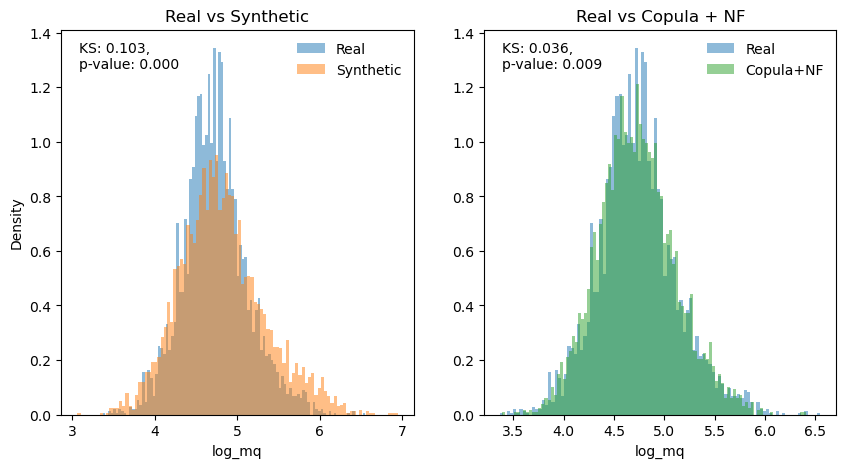

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].hist(df_real[variable], bins=100, alpha=0.5, label='Real', density=True)
ax[0].hist(df_nfvae[variable], bins=100, alpha=0.5, label='Synthetic', density=True)
ax[1].hist(df_real[variable], bins=100, alpha=0.5, label='Real', density=True)
ax[1].hist(df_copula_nf[variable], bins=100,color='tab:green', alpha=0.5, label='Copula+NF', density=True)
ax[0].text(0.05, 0.9, f'KS: {ks_real_nfvae.statistic:.3f},\np-value: {ks_real_nfvae.pvalue:.3f}', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, f'KS: {ks_real_copula_nf.statistic:.3f},\np-value: {ks_real_copula_nf.pvalue:.3f}', transform=ax[1].transAxes)

# plot pdf of normal distribution
#plt.plot(np.linspace(df_real[variable].min(), df_real[variable].max(), 100),
#            scipy.stats.norm.pdf(np.linspace(df_real[variable].min(), df_real[variable].max(), 100),
#                                  loc=np.mean(df_real[variable]),
#                                  scale=np.std(df_real[variable])),label='Normal', color='green')


#plt.hist(df_feat_shuffle['log_mq'], bins=100, alpha=0.5, label='Feature shuffled', density=True)
ax[0].set_xlabel(variable)
ax[1].set_xlabel(variable)
ax[0].set_ylabel('Density')
ax[0].set_title('Real vs Synthetic')
ax[1].set_title('Real vs Copula + NF')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

### Chi square: for dummies

In [43]:
data_1= df_real
data_2= df_nfvae

print('value counts_real:',data_1['flag_garage'].value_counts())
print('value counts_sample:',data_2['flag_garage'].value_counts())


df_chi= pd.DataFrame(columns=['chi2', 'p_value'], index=list(categoricals))
# chi-squared test for independence
from scipy.stats import chi2_contingency
for attribute in list(categoricals):

    contingency_table = pd.crosstab(data_1[attribute].reset_index(drop=True), data_2[attribute].reset_index(drop=True))
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    df_chi.loc[attribute,:] = [chi2, p_value]
    
# Null hypothesis: two distributions are the same
# Reject null hypothesis if p-value < 0.05:  two distributions are different

df_chi

value counts_real: flag_garage
0.0    27126
1.0    24926
Name: count, dtype: int64
value counts_sample: flag_garage
0.0    28713
1.0    23339
Name: count, dtype: int64


,chi2,p_value
Missing_energy_class,0.388705,0.532981
COD_CAT_A02,1.201845,0.272953
flag_garage,0.016209,0.898692
floor_3.0,0.0,1.0
floor_0.0,0.462209,0.496593
Low_energy_class,9.150208,0.002487
flag_air_conditioning_Missing,1.260353,0.261584
COD_CAT_A_01_07_08,0.000004,0.998501
floor_plus_4,0.052358,0.819009
ANNO_COSTRUZIONE_1965_1985,0.231653,0.630301


# OLD CODE

## Wasserstein distance between cells in grids: 

In [ ]:
import ot 
SWD_real_sample = ot.sliced_wasserstein_distance(grid_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_nfvae.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real.num_homes.to_numpy(), 
                               grid_nfvae.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_sample_null = ot.sliced_wasserstein_distance(grid_nfvae.loc[:, ['x', 'y']].to_numpy(), 
                               grid_null.loc[:, ['x', 'y']].to_numpy(), 
                               grid_nfvae.num_homes.to_numpy(), 
                               grid_null.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_real_null = ot.sliced_wasserstein_distance(grid_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_null.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real.num_homes.to_numpy(), 
                               grid_null.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_real_abl= ot.sliced_wasserstein_distance(grid_real.loc[:, ['x', 'y']].to_numpy(), 
                                    grid_ablation.loc[:, ['x', 'y']].to_numpy(), 
                                    grid_real.num_homes.to_numpy(), 
                                    grid_ablation.num_homes.to_numpy(), 
                                    n_projections=5000)


print (f"SWD real vs sample: {SWD_real_sample}", 
       f"SWD sample vs null: {SWD_sample_null}", 
       f"SWD real vs null: {SWD_real_null}")
print (f"SWD real vs ablation: {SWD_real_abl}")

#10000: 0.007543662781693349 23s
#1000: 0.007559389314730181 1.7s
#5000: 0.007512275448032315 9s 


In [ ]:
import scipy.stats as stats
WD_scipy = stats.wasserstein_distance_nd(u_values = grid_list_real.loc[:, ['x', 'y']].to_numpy(), v_values= grid_list_null.loc[:, ['x', 'y']].to_numpy(), u_weights= grid_list_real.num_homes.to_numpy(), v_weights=grid_list_null.num_homes.to_numpy())
WD_scipy

In [ ]:
import scipy.stats as stats
WD_scipy_real_samp = stats.wasserstein_distance_nd(u_values = grid_list_real.loc[:, ['x', 'y']].to_numpy(), v_values= grid_list_sample.loc[:, ['x', 'y']].to_numpy(), u_weights= grid_list_real.num_homes.to_numpy(), v_weights=grid_list_sample.num_homes.to_numpy())
WD_scipy_real_samp

In [ ]:
province_shapefile

In [ ]:
def Shuffle_attribute(grid_list,province_shapefile):
    
    # Find grid cells inside the province
    merged = gpd.sjoin(grid_list, province_shapefile, how='left', predicate='within')
    merged['in_province']= (~merged.index_right0.isna()).astype(int)
    grid_in_province=merged.drop(columns=['index_right0','index'])
    
    # Shuffle attribute num_homes in the grid cells that are inside the province
    grid_shuffled= merged.copy(deep=True)
    grid_shuffled.loc[grid_shuffled.in_province==1,'num_homes'] = np.random.permutation(grid_shuffled.loc[grid_shuffled.in_province==1,'num_homes'].values)
    return grid_shuffled, grid_in_province


# Shuffle num_homes in the grid cells that are inside the province
grid_real_shuffled, grid_province_real = Shuffle_attribute(grid_list_real, province_shapefile)
grid_nfvae_shuffled, grid_province_sample  = Shuffle_attribute(grid_list_sample, province_shapefile)
grid_nfvae_shuffled

In [ ]:
# compute distance matrix for shuffled
import ot 
SWD_real_shuff_in = ot.sliced_wasserstein_distance(grid_province_real.loc[grid_province_real.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_real_shuffled.loc[grid_real_shuffled.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_province_real.loc[grid_province_real.in_province==1, 'num_homes'].to_numpy(), 
                               grid_real_shuffled.loc[grid_real_shuffled.in_province==1, 'num_homes'].to_numpy(), 
                               n_projections=5000)

SWD_real_shuff_all = ot.sliced_wasserstein_distance(grid_province_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                               grid_province_real.loc[:, 'num_homes'].to_numpy(), 
                               grid_real_shuffled.loc[:, 'num_homes'].to_numpy(), 
                               n_projections=5000)


SWD_sample_shuff_in = ot.sliced_wasserstein_distance(grid_province_sample.loc[grid_province_sample.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_nfvae_shuffled.loc[grid_nfvae_shuffled.in_province==1, ['x', 'y']].to_numpy(), 
                               grid_province_sample.loc[grid_province_sample.in_province==1, 'num_homes'].to_numpy(), 
                               grid_nfvae_shuffled.loc[grid_nfvae_shuffled.in_province==1, 'num_homes'].to_numpy(), 
                               n_projections=5000)

SWD_sample_shuff_all = ot.sliced_wasserstein_distance(grid_province_sample.loc[:, ['x', 'y']].to_numpy(),
                                    grid_nfvae_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                                    grid_province_sample.loc[:, 'num_homes'].to_numpy(), 
                                    grid_nfvae_shuffled.loc[:, 'num_homes'].to_numpy(), 
                                    n_projections=5000)
'''
SWD_real_shuff = ot.sliced_wasserstein_distance(grid_list_real.loc[:, ['x', 'y']].to_numpy(), 
                               grid_real_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                               grid_list_real.num_homes.to_numpy(), 
                               grid_real_shuffled.num_homes.to_numpy(), 
                               n_projections=5000)

SWD_sample_shuff = ot.sliced_wasserstein_distance(grid_list_sample.loc[:, ['x', 'y']].to_numpy(), 
                               grid_nfvae_shuffled.loc[:, ['x', 'y']].to_numpy(), 
                               grid_list_sample.num_homes.to_numpy(), 
                               grid_nfvae_shuffled.num_homes.to_numpy(), 
                               n_projections=5000)'''

print(f"SWD Real vs Real shuffled (IN PROV): {SWD_real_shuff_in}", f"SWD Real vs Real shuffled (ALL): {SWD_real_shuff_all}")
print(f"SWD Sample vs Sample shuffled (IN PROV): {SWD_sample_shuff_in}", f"SWD Sample vs Sample shuffled (ALL): {SWD_sample_shuff_all}")

### ER scipy

In [ ]:
import scipy.stats as stats #not working 
def sliced_wasserstein(X, Y, num_proj):
    '''Takes:
        X: 2d (or nd) histogram
        Y: 2d (or nd) histogram
        num_proj: Number of random projections to compute the mean over
        ---
        returns:
        mean_emd_dist'''
    #% Implementation of the (non-generalized) sliced wasserstein (EMD) for 2d distributions as described here: https://arxiv.org/abs/1902.00434 %#
    # X and Y should be a 2d histogram 
    # Code adapted from stackoverflow user: Dougal - https://stats.stackexchange.com/questions/404775/calculate-earth-movers-distance-for-two-grayscale-images
    dim = X.shape[1]
    ests = []
    
    for x in range(num_proj):
        
        # sample uniformly from the unit sphere
        dir = np.random.rand(dim)
        dir /= np.linalg.norm(dir)

        # project the data
        X_proj = X @ dir
        Y_proj = Y @ dir
        
        # compute 1d wasserstein
        ests.append(stats.wasserstein_distance(np.arange(dim), np.arange(dim), X_proj, Y_proj))
    return np.mean(ests)


sliced_wasserstein(grid_real.to_numpy(), grid_nfvae.to_numpy(), num_proj=100)

## JACOPO AUTOCORRELATION

#### Load functions
Copy past functions to assign Hedonic Price

In [ ]:
#%% Import libraries
import pandas as pd
import numpy as np
import sys
import pyfixest as pf
from tqdm import tqdm
import pickle

from pyfixest.estimation import feols
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

sys.path += ['../src/'] 
import utils
import config


# 40 seconds
abm_path = "ISP_data_for_ABM/ISP_ABM_up_to_2024_08_0001.csv"
data = pd.read_csv(jl_vae.path_intermediate + abm_path, index_col = 0)
geo_dict = jl_vae.load_geo_data()

# these need to be added to the generated data for predicting with hedonic regression
year_erogaz = [f'year_erogaz_{u}' for u in [u for u in range(2016, 2025)]] 
# Trained Hedonic Regression
train_path = '/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_OMI_id.pkl'
# Load ISP data for the ABM and clean it 
data_path = '/data/housing/data/intermediate/ISP_data_for_ABM/ISP_ABM_up_to_2024_08.csv'
isp = pd.read_csv(data_path,dtype=str,encoding='latin1',na_values=config.default_missing)

drop_col = ['floor_numeric','NUM_MQ_SUPERF_COMM','COD_CAT_CATASTALE','year_erogaz']
isp = isp.drop(columns=drop_col)
isp = utils.CorrectTypes_ABM(isp)

def HedonicRegression_PriceTrain (train_data,sp_fix_eff,save):
    """
    Function to compute the hedonic price of the houses in the synthetic population
    Inputs:
     - train_data: ISP data
     - sp_fix_eff: spatial fixed effects (we start using PRO_COM)
     - save: flag that is True if you want to save the regression parameters in this file f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl'. 

    Outputs:
     - reg_risk: regression objetc
    """
    # Drop colinearity variables
    drop_coliniarity= ['ANNO_COSTRUZIONE_1500_1965','Medium_energy_class',
                        'COD_CAT_A_04_05','floor_0.0','year_erogaz_2016']
    train_data = train_data.drop(columns=drop_coliniarity)

    # Add dummies to formula: 
    floor_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('floor_')]))
    year_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('year_erogaz_20')]))
    energy_class_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('_energy_class')]))
    ANNO_COSTRUZIONE_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('ANNO_COSTRUZIONE')]))
    COD_CAT_dummies = ' + '.join(list(train_data.columns[train_data.columns.str.contains('COD_CAT_')]))

    dummies_vec = COD_CAT_dummies + '+' + ANNO_COSTRUZIONE_dummies + '+' + energy_class_dummies + ' + ' + floor_dummies + '+' + year_dummies

    # Regression specification
    base_features = 'flag_garage + flag_pertinenza + flag_air_conditioning + flag_multi_floor +' + dummies_vec
    mq_feature = 'log_mq' 

    eq_regr_risk = 'log_price ~ scenario_Risk +' + mq_feature + '+' + base_features + '|' +  sp_fix_eff  # + C(month_erogaz) year_erogaz_prov +
    
    # Train regression
    reg_risk = feols(fml=eq_regr_risk, data=train_data, drop_intercept=False ,vcov = {"CRV1":sp_fix_eff})
    if save==True:
        model_state = {"_beta_hat": reg_risk._beta_hat,
                    "_coefnames": reg_risk._coefnames,
                    "_se": reg_risk._se,
                    "_tstat": reg_risk._tstat,
                    "_pvalue": reg_risk._pvalue,
                    "_conf_int": reg_risk._conf_int,
                    "_vcov": reg_risk._vcov,
                    "_fml": reg_risk._fml,
                    "_sumFE": reg_risk._sumFE,
                    "_fixef": reg_risk._fixef,
                    "_fixef_dict": reg_risk._fixef_dict,
                    "_data": reg_risk._data}
        with open(f'/data/housing/data/intermediate/HedonicRegressionABM/reg_risk_{sp_fix_eff}.pkl', 'wb') as handle:
            pickle.dump(model_state, handle)

    return reg_risk

def Predict_function(isp,train_path,test_data):
    """
    Function to estimate the hedonic price of a house. 

    Input variables:
        -isp: data from ISP data (used to initialize the regression model)
        - train_path: path to coefficients af the trained model
        - test_data: data for which you want to estimate the home hedonic price

    Output:
        - test_data: same Dataframe as the input with the estimated hedonic price corrected by inflation
    and flood_risk effects (``price_corrected``). 
    """

    # Initialise dummy regresion
    reg_risk = HedonicRegression_PriceTrain(isp.sample(1000),'PRO_COM',save=False)

    # Update reg_risk with good params
    with open(train_path, 'rb') as handle:
        model_state = pickle.load(handle)

    reg_risk._beta_hat = model_state["_beta_hat"]
    reg_risk._coefnames = model_state["_coefnames"]
    reg_risk._se = model_state["_se"]
    reg_risk._tstat = model_state["_tstat"]
    reg_risk._pvalue = model_state["_pvalue"]
    reg_risk._conf_int = model_state["_conf_int"]
    reg_risk._vcov = model_state["_vcov"]
    reg_risk._fml = model_state["_fml"]
    reg_risk._sumFE = model_state["_sumFE"]
    reg_risk._fixef = model_state["_fixef"]
    reg_risk._fixef_dict = model_state["_fixef_dict"]
    reg_risk._data = model_state["_data"]

    test_data['log_price_estimation'] = reg_risk.predict(test_data)

    
    # Correct price estimations with Risk coefficient and average Inflation
    _, df_coeff = utils.ImportantCoefficients(reg_risk,['Risk'])

    # Risk correction
    test_data['price_corrected'] = test_data['log_price_estimation'] - (df_coeff.loc['scenario_Risk','Coefficient']*test_data['scenario_Risk'])

    # Correct inflation
    df_year,_ = utils.ImportantCoefficients(reg_risk,['year']) # av_inflation
    avg_inflation = df_year.Coefficient.mean()
    
    for i in df_year.index:
        test_data['price_corrected'] = test_data['price_corrected'] - (df_year.loc[i,'Coefficient']*test_data[i])
    test_data['price_corrected'] = test_data['price_corrected'] + avg_inflation
    
    # Remove log and drop unnecessary columns
    test_data['price_corrected'] = np.exp(test_data['price_corrected'])
    test_data.drop(columns='log_price_estimation',inplace=True)
    
        
    return test_data
    


In [ ]:
def add_cat_features(df):
    df["energy_class"] = df[[u for u in df.columns if "_energy" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]
    df["COD_CAT"] = [u[8:] for u in df[[u for u in df.columns if "COD_CAT_" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    df["anno_costruzione"] = [u[17:] for u in df[[u for u in df.columns if "ANNO_COSTRUZIONE" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    return df


### One province

In [ ]:
# paths for importing synthetic populations

# choose the province
prov = "AN" # AO
# get the cod prov (number)
cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].item()

# all trained models have these settings
date_nf = "241203"
# without the prices
# date_vae = "240107"
# synth_pops = jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250110"
# with the prices
date_vae = "250709price_"
synth_pops = jl_vae.path_pop_synth + f"pop_samples"

date_data = "250110"

real_pops = jl_vae.path_pop_synth + f"pop_samples/pop_real_with_hedonic_price"

date_95 = "250703"
date_data = "250110"

vae_data = "full"

# date_abl = "250523" 
# date_abl = "25071" 
date_abl = "250710" 
ablation_pops = jl_vae.path_pop_synth + f"pop_samples_ablation"

In [ ]:
# assign geographical features and prices ~1 minute
vae_loaded = jl_vae.load_vae_province(prov, 
                                      jl_vae.path_pop_synth + f"ablation_vae/settings_{vae_data}_{date_abl}{prov}.pkl",
                                      jl_vae.path_pop_synth + f"ablation_vae/vae_{vae_data}_{date_abl}{prov}.pkl"
                                      )
len(vae_loaded.full_df)

df_abl = vae_loaded.get_sample_from_vae(nf_dict = None, n_samples = 100000, seed = 800)
df_abl = utils.spatial_matching_ABM(df_abl,
                                       hydro_risk = geo_dict["hydro_risk"],
                                       census = geo_dict["census"],
                                       omi_og = geo_dict["omi_og"],
                                       cap = geo_dict["cap"]).rename({"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})

# I set year erogazione as the last year we have 
df_abl[year_erogaz] = False
df_abl[year_erogaz[-1]] = True
# df_sample = df_sample.sample(n = len(df_real), replace = False)

# assign the hedonic price to all samples
#df_abl_with_price = Predict_function(isp, train_path, df_abl).rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
# df_sample_with_price.to_csv(jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250210/pop_synth_full_250210{prov}_{h}.csv")
        

In [ ]:
# assign geographical features and prices ~1 minute
vae_loaded = jl_vae.load_vae_province(prov, 
                                      jl_vae.path_pop_synth + f"ablation_vae/settings_{vae_data}_{date_abl}{prov}.pkl",
                                      jl_vae.path_pop_synth + f"ablation_vae/vae_{vae_data}_{date_abl}{prov}.pkl"
                                      )
len(vae_loaded.full_df)

df_abl = vae_loaded.get_sample_from_vae(nf_dict = None, n_samples = 100000, seed = 800)
df_abl = utils.spatial_matching_ABM(df_abl,
                                       hydro_risk = geo_dict["hydro_risk"],
                                       census = geo_dict["census"],
                                       omi_og = geo_dict["omi_og"],
                                       cap = geo_dict["cap"]).rename({"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})

# I set year erogazione as the last year we have 
df_abl[year_erogaz] = False
df_abl[year_erogaz[-1]] = True
# df_sample = df_sample.sample(n = len(df_real), replace = False)

# assign the hedonic price to all samples
# df_abl_with_price = Predict_function(isp, train_path, df_abl).rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
#df_abl_with_price = df_abl.rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"}).copy()
# df_sample_with_price.to_csv(jl_vae.path_pop_synth + f"pop_samples/pop_synth_with_hedonic_price_250210/pop_synth_full_250210{prov}_{h}.csv")
        

In [ ]:
df_real = pd.read_csv(real_pops + f"/pop_real_full_250110{prov}.csv", index_col = 0)
# df_sample_all = pd.read_csv(synth_pops + f"/pop_synth_full_{date_vae}{prov}.csv", index_col = 0).query("prov_abbrv == @prov")
df_sample_all = pd.read_csv(synth_pops + f"/synthetic_pop_full_{date_vae}{prov}.csv", index_col = 0)

df_real = add_cat_features(df_real)
df_sample_all = add_cat_features(df_sample_all)
df_sample = df_sample_all.sample(n = int(len(df_real)), random_state = 1111)
# df_abl = pd.read_csv(ablation_pops + f"/synthetic_pop_{vae_data}_{date_abl}{prov}.csv", index_col = 0).sample(n = int(len(df_real)), replace = True, random_state = 1111)
#df_sample_abl = (df_abl_with_price.query("COD_PROV == @cod_prov").sample(n = int(len(df_real)), random_state = 1111)
#                 .assign(CAP = lambda x: x["CAP"].astype(int),
#                         PRO_COM = lambda x: x["PRO_COM"].astype(int)))

df_sample_abl = (df_abl.query("COD_PROV == @cod_prov").sample(n = int(len(df_real)), random_state = 1111)
                 .assign(CAP = lambda x: x["CAP"].astype(int),
                         PRO_COM = lambda x: x["PRO_COM"].astype(int),
                         x = lambda x: x["GEO_LONGITUDINE_BENE_ROUNDED"].astype(float),
                         y = lambda x: x["GEO_LATITUDINE_BENE_ROUNDED"].astype(float))) # I ADDED THIS (ARI)

In [ ]:
len(df_sample), len(df_real), len(df_sample_abl)

In [ ]:
fig, axes = sbp(ncols = 3, figsize = (12,4), sharex = True, sharey = True)

for j,df_plot in enumerate([df_real.assign(flag_garage = lambda x: x["flag_garage"] == 1), df_sample, df_sample_abl[~df_sample_abl["PRO_COM"].isna()]]):
    sns.scatterplot(data = df_plot,
                    hue = "flag_garage", 
                    # hue = "flag_garage", 
                    x = "x", y = "y", s = 2, ax = axes[j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[j].set_title("Dati " + ["reali", "sintetici", "ablation"][j] + " - " + prov, fontsize = 19)
    axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_visible(False)
# axes[0].legend().set_visible(False)
    axes[j].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")

### Spatial Autocorrelation

In [ ]:
df_sample.columns

In [ ]:
# euclidean distance geographical coordinates
def compute_distance_matrix(df):
    M = np.array(df[["x", "y"]])
    D = (((np.repeat(M[:,:,None], len(df), axis = 2) - np.repeat(M[:,:,None], len(df), axis = 2).transpose(2,1,0))**2).sum(axis = 1))
    return D

# compute Morans index
# W is the distance weight, can be modified 
def compute_spatial_autocorrelation(df, var):
    D = compute_distance_matrix(df)
    W = np.exp(-D)
    return get_moransI(W,np.array(df[var]))


In [ ]:
var = "flag_garage"

In [ ]:
compute_spatial_autocorrelation(df_sample, var)

In [ ]:
compute_spatial_autocorrelation(df_real, var)

In [ ]:
compute_spatial_autocorrelation(df_sample_abl, var)

### Neighbors distribution

In [ ]:
D_sample = compute_distance_matrix(df_sample)
D_real = compute_distance_matrix(df_real)
D_sample_abl = compute_distance_matrix(df_sample_abl)
    

In [ ]:
np.var(D_sample), np.var(D_real), np.var(D_sample_abl)

In [ ]:
fig, axes = sbp(ncols = 3, figsize = (13, 3), sharex = True, sharey = True)
for i,D in enumerate([D_sample, D_real, D_sample_abl]):
    sns.histplot((D < 0.0001).sum(axis = 1), ax = axes[i], binwidth = 5)

### Correlation CAP

In [ ]:
fig, axes = sbp(ncols = 2, figsize = (7,3), sharex = True, sharey = True)
sns.scatterplot(data = df_sample["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP"),
                x = "count_x", y = "count_y", ax = axes[0])

sns.scatterplot(data = df_sample_abl["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP"),
                x = "count_x", y = "count_y", ax = axes[1])
axes[0].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)
axes[1].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)

In [ ]:
df_sample["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP")[["count_x", "count_y"]].corr().iloc[0,1]

In [ ]:
df_sample_abl["CAP"].value_counts().reset_index().merge(df_real["CAP"].value_counts().reset_index(), how = "outer", on = "CAP")[["count_x", "count_y"]].corr().iloc[0,1]

### Correlation PRO_COM

In [ ]:
fig, axes = sbp(ncols = 2, figsize = (7,3), sharex = True, sharey = True)
sns.scatterplot(data = df_sample["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM"),
                x = "count_x", y = "count_y", ax = axes[0])

sns.scatterplot(data = df_sample_abl["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM"),
                x = "count_x", y = "count_y", ax = axes[1])
axes[0].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)
axes[1].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)

In [ ]:
df_sample["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM")[["count_x", "count_y"]].corr().iloc[0,1]

In [ ]:
df_sample_abl["PRO_COM"].value_counts().reset_index().merge(df_real["PRO_COM"].value_counts().reset_index(), how = "outer", on = "PRO_COM")[["count_x", "count_y"]].corr().iloc[0,1]

### Correlation OMI_id

In [ ]:
fig, axes = sbp(ncols = 2, figsize = (7,3), sharex = True, sharey = True)
sns.scatterplot(data = df_sample["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id"),
                x = "count_x", y = "count_y", ax = axes[0])

sns.scatterplot(data = df_sample_abl["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id"),
                x = "count_x", y = "count_y", ax = axes[1])
axes[0].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)
axes[1].axline(xy1 = [0,0], xy2 = [1,1], color = "red", linestyle = "dashed", alpha = 0.3)

In [ ]:
df_sample["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id")[["count_x", "count_y"]].corr().iloc[0,1]

In [ ]:
df_sample_abl["OMI_id"].value_counts().reset_index().merge(df_real["OMI_id"].value_counts().reset_index(), how = "outer", on = "OMI_id")[["count_x", "count_y"]].corr().iloc[0,1]